# Download Data

In [ ]:
%pip install git+https://github.com/openai/CLIP.git open_clip_torch
%pip install git-lfs

In [1]:
import os
data_dir = 'data'

annotations_folder = os.path.join(data_dir, "annotations")
if not os.path.exists(annotations_folder):
    print(f"{annotations_folder} folder does not exist, downloading...")
    !wget -P $data_dir http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip $data_dir/annotations_trainval2017.zip -d $data_dir

coco_val_folder = os.path.join(data_dir, "val2017")
if not os.path.exists(coco_val_folder):
    print(f"{coco_val_folder} folder does not exist, downloading...")
    !wget -P $data_dir http://images.cocodataset.org/zips/val2017.zip
    !unzip $data_dir/val2017.zip -d $data_dir

flickr8k_folder = os.path.join(data_dir, "Flickr8k_Dataset")
if not os.path.exists(flickr8k_folder):
    print(f"{flickr8k_folder} folder does not exist, downloading...")
    !wget -P $data_dir "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
    !unzip -q $data_dir/flickr8k.zip -d $flickr8k_folder
    
    !echo "Downloaded Flickr8k dataset successfully."

In [2]:
from transformers import AutoConfig, AutoModel, AutoProcessor
import open_clip
import sys
sys.path.append('../..')
import torch
from torchvision.datasets import CocoCaptions, Flickr8k
from PIL import Image
import clip
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

2025-02-27 15:26:21.927145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Encoder Function

In [2]:
from transformers import AutoConfig, AutoModel
import os
import shutil
from safetensors.torch import load_file

def load_triplet_clip_encoders(
    repo_name="TripletCLIP/CC12M_TripletCLIP_ViTB12",
    text_path='',
    image_path='',
    work_dir="/content",
    device="cuda"
):
    repo_url = f"https://huggingface.co/{repo_name}"

    repo_folder_name = repo_name.split("/")[-1]  # e.g. CC12M_TripletCLIP_ViTB12
    target_path = os.path.join(work_dir, repo_folder_name)

    if not os.path.exists(target_path):
        !git clone $repo_url $target_path
        !cd $target_path
        !git lfs install

    text_config_path = os.path.join(target_path, text_path)
    image_config_path = os.path.join(target_path, image_path)

    text_config = AutoConfig.from_pretrained(text_config_path, local_files_only=True, trust_remote_code=True, device_map="auto")
    image_config = AutoConfig.from_pretrained(image_config_path, local_files_only=True, trust_remote_code=True, device_map="auto")

    text_encoder = AutoModel.from_config(text_config, trust_remote_code=True)
    image_encoder = AutoModel.from_config(image_config, trust_remote_code=True)

    text_encoder.load_state_dict(load_file(os.path.join(text_config_path, 'model.safetensors')), strict=False)
    image_encoder.load_state_dict(load_file(os.path.join(image_config_path, 'model.safetensors')), strict=False)

    text_encoder.to(device)
    image_encoder.to(device)

    text_encoder.eval()
    image_encoder.eval()

    return text_encoder, image_encoder


class clip_encoder(object):
    def __init__(self, model, type, device):
        self.model = model
        assert type in ['image', 'text'], "type must be either 'image' or 'text'"
        self.type = type
        self.device = device
        self.model.to(device)

    def __call__(self, input):
        input = input.to(self.device)
        if self.type == 'image':
            return self.model.encode_image(input)
        elif self.type == 'text':
            return self.model.encode_text(input)
        else:
            raise ValueError("type must be either 'image' or 'text'")


def load_clip_encoders(
    repo_name="hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
    work_dir="/content",
    device="cuda"
):
    model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(repo_name)
    return clip_encoder(model, 'text', device), clip_encoder(model, 'image', device)
    
    
def transform(
    dataset,
    image_encoder,
    text_encoder,
    processor,
    tokenizer,
    device='cuda',
    sample_size=None
):
    from itertools import islice
    image_features = []
    text_features = []

    if sample_size is not None and sample_size <= 5000:
        dataset_iter = islice(dataset, sample_size)
    else:
        dataset_iter = dataset

    with torch.no_grad():
        for image, captions in tqdm(dataset_iter, total=sample_size):
            image_input = processor(images=image, return_tensors="pt").to(device)
            image_features.append(image_encoder(image_input))

            captions = captions[0:5]
            caption_input = tokenizer(captions).to(device)
            text_features.extend(text_encoder(caption_input).text_embeds)

        image_features = torch.stack(image_features).squeeze()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        print(image_features.shape)
        text_features = torch.stack(text_features)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    return image_features, text_features

def transform_clip(
    dataset,
    image_encoder,
    text_encoder,
    processor,
    tokenizer,
    device='cuda',
    sample_size=None
):
    from itertools import islice
    image_features = []
    text_features = []

    if sample_size is not None and sample_size <= 5000:
        dataset_iter = islice(dataset, sample_size)
    else:
        dataset_iter = dataset

    with torch.no_grad():
        for image, captions in tqdm(dataset_iter, total=sample_size):
            image_input = processor(images=image, return_tensors="pt")['pixel_values'].to(device)
            image_features.append(image_encoder(image_input))

            captions = captions[0:5]
            caption_input = tokenizer(captions).to(device)
            text_features.extend(text_encoder(caption_input))

        image_features = torch.stack(image_features).squeeze()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        print(image_features.shape)
        text_features = torch.stack(text_features)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    return image_features, text_features

# Dataset

In [4]:
coco = CocoCaptions(root=coco_val_folder, annFile=os.path.join(annotations_folder, 'captions_val2017.json'), transform=None)
flickr8k = Flickr8k(root=os.path.join(flickr8k_folder, 'Images'), ann_file=os.path.join(flickr8k_folder, 'captions.txt'), transform=None)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


# Processor and Tokenizer

In [5]:
processor = AutoProcessor.from_pretrained('openai/clip-vit-base-patch32')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# Encoder

In [7]:
text_encoder_t, image_encoder_t = load_triplet_clip_encoders(repo_name='TripletCLIP/CC12M_TripletCLIP_ViTB12',text_path='text-encoder',image_path='vision-encoder', work_dir=data_dir, device=device)
text_encoder_n, image_encoder_n = load_triplet_clip_encoders(repo_name='TripletCLIP/CC12M_NegCLIP_ViTB12',text_path='text-encoder',image_path='vision-encoder', work_dir=data_dir, device=device)
text_encoder_l, image_encoder_l = load_triplet_clip_encoders(repo_name='TripletCLIP/CC12M_LaCLIP_ViTB12',text_path='text-encoder',image_path='vision-encoder', work_dir=data_dir, device=device)
text_encoder_npp, image_encoder_npp = load_triplet_clip_encoders(repo_name='TripletCLIP/CC12M_NegCLIPPP_ViTB12',text_path='text-encoder',image_path='vision-encoder', work_dir=data_dir, device=device)
text_encoder_laion2b, image_encoder_laion2b = load_clip_encoders(repo_name='hf-hub:laion/CLIP-ViT-B-32-laion2B-s34B-b79K', work_dir=data_dir, device=device)

## Feature Extraction

In [ ]:
sample_size = 5000
coco_image_features_t, coco_text_features_t = transform(coco, image_encoder_t, text_encoder_t, processor, tokenizer, device, sample_size=sample_size)
coco_image_features_n, coco_text_features_n = transform(coco, image_encoder_n, text_encoder_n, processor, tokenizer, device, sample_size=sample_size)
coco_image_features_l, coco_text_features_l = transform(coco, image_encoder_l, text_encoder_l, processor, tokenizer, device, sample_size=sample_size)
coco_image_features_npp, coco_text_features_npp = transform(coco, image_encoder_npp, text_encoder_npp, processor, tokenizer, device, sample_size=sample_size)
coco_image_features_laion2b, coco_text_features_laion2b = transform_clip(coco, image_encoder_laion2b, text_encoder_laion2b, processor, tokenizer, device, sample_size=sample_size)

sample_size = 8000
# flickr8k_image_features_t, flickr8k_text_features_t = transform(flickr8k, image_encoder_t, text_encoder_t, processor, tokenizer, device, sample_size=sample_size)
# flickr8k_image_features_n, flickr8k_text_features_n = transform(flickr8k, image_encoder_n, text_encoder_n, processor, tokenizer, device, sample_size=sample_size)
# flickr8k_image_features_l, flickr8k_text_features_l = transform(flickr8k, image_encoder_l, text_encoder_l, processor, tokenizer, device, sample_size=sample_size)
# flickr8k_image_features_npp, flickr8k_text_features_npp = transform(flickr8k, image_encoder_npp, text_encoder_npp, processor, tokenizer, device, sample_size=sample_size)
# flickr8k_image_features_laion2b, flickr8k_text_features_laion2b = transform_clip(flickr8k, image_encoder_laion2b, text_encoder_laion2b, processor, tokenizer, device, sample_size=sample_size)

# Save Features

In [71]:
torch.save(coco_image_features_t, os.path.join(data_dir, 'coco_image_features_t.pt'))
torch.save(coco_text_features_t, os.path.join(data_dir, 'coco_text_features_t.pt'))
torch.save(coco_image_features_n, os.path.join(data_dir, 'coco_image_features_n.pt'))
torch.save(coco_text_features_n, os.path.join(data_dir, 'coco_text_features_n.pt'))
torch.save(coco_image_features_l, os.path.join(data_dir, 'coco_image_features_l.pt'))
torch.save(coco_text_features_l, os.path.join(data_dir, 'coco_text_features_l.pt'))
torch.save(coco_image_features_npp, os.path.join(data_dir, 'coco_image_features_npp.pt'))
torch.save(coco_text_features_npp, os.path.join(data_dir, 'coco_text_features_npp.pt'))
torch.save(coco_image_features_laion2b, os.path.join(data_dir, 'coco_image_features_laion2b.pt'))
torch.save(coco_text_features_laion2b, os.path.join(data_dir, 'coco_text_features_laion2b.pt'))

# Load Features

In [3]:
coco_image_features_t = torch.load(os.path.join(data_dir, 'coco_image_features_t.pt'))
coco_text_features_t = torch.load(os.path.join(data_dir, 'coco_text_features_t.pt'))
coco_image_features_n = torch.load(os.path.join(data_dir, 'coco_image_features_n.pt'))
coco_text_features_n = torch.load(os.path.join(data_dir, 'coco_text_features_n.pt'))
coco_image_features_l = torch.load(os.path.join(data_dir, 'coco_image_features_l.pt'))
coco_text_features_l = torch.load(os.path.join(data_dir, 'coco_text_features_l.pt'))
coco_image_features_npp = torch.load(os.path.join(data_dir, 'coco_image_features_npp.pt'))
coco_text_features_npp = torch.load(os.path.join(data_dir, 'coco_text_features_npp.pt'))
coco_image_features_laion2b = torch.load(os.path.join(data_dir, 'coco_image_features_laion2b.pt'))
coco_text_features_laion2b = torch.load(os.path.join(data_dir, 'coco_text_features_laion2b.pt'))

/tmp/ipykernel_1570274/857984727.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coco_image_features_t = torch.load(os.path.join(data_dir, 'coco_image_features_t.pt'))
/

# Similarity

In [9]:
def rotate_and_calc_similarity(image_features, text_features):

    # ========== 1) 计算全局均值并归一化 ==========
    # image 全局均值: (D,)
    mean_image = image_features.mean(dim=0)
    # text 全局均值:  (D,)
    mean_text  = text_features.mean(dim=0)

    # 归一化 (若想直接点乘当作余弦相似度, image/text_features 本身也需归一化)
    mean_image_norm = mean_image / (mean_image.norm() + 1e-12)
    mean_text_norm  = mean_text  / (mean_text.norm()  + 1e-12)

    # ========== 2) 计算夹角 theta 并构造二维平面内的正交向量 ==========
    # cos_angle = a·b
    cos_angle = torch.dot(mean_image_norm, mean_text_norm)
    # 防止浮点误差导致 acos 输入超出 [-1,1]
    cos_angle = torch.clamp(cos_angle, -1.0, 1.0)
    theta = torch.acos(cos_angle)  # 弧度

    sin_angle = torch.sqrt(1 - cos_angle**2 + 1e-12)
    # 在 (mean_image_norm, mean_text_norm) 所张平面上，构造与 mean_image_norm 正交的单位向量 v
    v = (mean_text_norm - cos_angle * mean_image_norm) / (sin_angle + 1e-12)

    # ========== 3) 在 (mean_image_norm, v) 平面内对 image_features 做旋转 ==========
    # 投影系数
    proj_a = image_features @ mean_image_norm  # (N,)
    proj_v = image_features @ v                # (N,)

    # 2D 旋转
    # new_a = a*cosθ - v*sinθ
    # new_v = a*sinθ + v*cosθ
    rotated_proj_a = proj_a * torch.cos(theta) - proj_v * torch.sin(theta)  # (N,)
    rotated_proj_v = proj_a * torch.sin(theta) + proj_v * torch.cos(theta)  # (N,)

    # 在平面内的分量(旋转后)
    rotated_parallel = (rotated_proj_a.unsqueeze(1) * mean_image_norm.unsqueeze(0)
                      + rotated_proj_v.unsqueeze(1) * v.unsqueeze(0))

    # 原本在平面内的分量
    orig_parallel = (proj_a.unsqueeze(1) * mean_image_norm.unsqueeze(0)
                   + proj_v.unsqueeze(1) * v.unsqueeze(0))

    # 正交分量(不在平面内, 保持不变)
    orthogonal_component = image_features - orig_parallel

    # 旋转后的图像特征 (N, D)
    rotated_image_features = rotated_parallel + orthogonal_component

    # ========== 4) 计算相似度矩阵 (N, 5N) ==========
    # 如果想用余弦相似度, 这里要保证 rotated_image_features 与 text_features 已各自归一化。
    # 否则就是一般点乘。
    similarity_matrix = rotated_image_features @ text_features.T  # (N, 5N)

    # ========== 5) 通过广播为 "正例" 与 "负例" 构造布尔掩码 ==========
    # 对第 i 行(图像 i), 正例对应的列区间是 [5*i, ..., 5*i+4]
    #   => j_idx // 5 == i_idx

    N = image_features.size(0)
    i_idx = torch.arange(N, device=similarity_matrix.device).unsqueeze(1).expand(N, 5*N)
    j_idx = torch.arange(5*N, device=similarity_matrix.device).unsqueeze(0).expand(N, 5*N)

    pos_mask = (j_idx // 5 == i_idx)  # 形状 (N, 5N), True 表示匹配
    # 所有正例相似度 => (N*5,) 向量
    pos_sims = similarity_matrix[pos_mask]
    # 如果你想分别取 "每个图像 vs. 它的 5 条文本" 的平均，可以 reshape => (N,5) 再 mean
    # 这会先对每张图像5个caption做平均，再对 N 张图像平均
    mean_pos = pos_sims.view(N, 5).mean()

    # 负例相似度(不匹配)
    neg_sims = similarity_matrix[~pos_mask]  # (N*(5N-5),)
    mean_neg = neg_sims.mean()

    return mean_pos.item(), mean_neg.item()

In [12]:
import pandas as pd

coco_sim_pos_t, coco_sim_neg_t = rotate_and_calc_similarity(coco_image_features_t, coco_text_features_t)
coco_sim_pos_n, coco_sim_neg_n = rotate_and_calc_similarity(coco_image_features_n, coco_text_features_n)
coco_sim_pos_l, coco_sim_neg_l = rotate_and_calc_similarity(coco_image_features_l, coco_text_features_l)
coco_sim_pos_npp, coco_sim_neg_npp = rotate_and_calc_similarity(coco_image_features_npp, coco_text_features_npp)
coco_sim_pos_laion2b, coco_sim_neg_laion2b = rotate_and_calc_similarity(coco_image_features_laion2b, coco_text_features_laion2b)

data = {
    "Model": ["TripletCLIP", "NegCLIP", "LaCLIP", "NegCLIP++", "Laion2B"],
    "Positive Similarity": [coco_sim_pos_t, coco_sim_pos_n, coco_sim_pos_l, coco_sim_pos_npp, coco_sim_pos_laion2b],
    "Negative Similarity": [coco_sim_neg_t, coco_sim_neg_n, coco_sim_neg_l, coco_sim_neg_npp, coco_sim_neg_laion2b],
    "Posi - Neg ": [coco_sim_pos_t - coco_sim_neg_t, coco_sim_pos_n - coco_sim_neg_n, coco_sim_pos_l - coco_sim_neg_l, coco_sim_pos_npp - coco_sim_neg_npp, coco_sim_pos_laion2b - coco_sim_neg_laion2b],
}
df = pd.DataFrame(data)
print(df)

         Model  Positive Similarity  Negative Similarity  Posi - Neg 
0  TripletCLIP             0.786513             0.682487     0.104026
1      NegCLIP             0.637368             0.478758     0.158610
2       LaCLIP             0.507776             0.366787     0.140988
3    NegCLIP++             0.648507             0.493305     0.155203
4      Laion2B             0.577283             0.323815     0.253469


# Retrieval

In [4]:
import torch

def evaluate_retrieval(image_features, text_features, num_captions=5):
    """
    评估 image-to-text (I2T) 和 text-to-image (T2I) 的检索性能指标。
    
    Args:
        image_features (torch.Tensor): shape 为 (N, D) 的图片特征张量，其中 N 为图片数量。
        text_features (torch.Tensor): shape 为 (N * num_captions, D) 的文本特征张量，每张图片对应 num_captions 个 caption。
        num_captions (int): 每张图片对应的 caption 数量（默认 5）。
    
    Returns:
        dict: 包含以下键值对的字典：
            {
                'I2T_top1': float,  # 图片检索文本 Top1 准确率
                'I2T_top5': float,  # 图片检索文本 Top5 准确率
                'I2T_top10': float, # 图片检索文本 Top10 准确率
                'T2I_top1': float,  # 文本检索图片 Top1 准确率
                'T2I_top5': float,  # 文本检索图片 Top5 准确率
                'T2I_top10': float, # 文本检索图片 Top10 准确率
            }
    """
    # 确保文本数量与图片数量及每张图片的 caption 数匹配
    num_images = image_features.size(0)
    assert text_features.size(0) == num_images * num_captions, "文本特征数量与图片数量不匹配！"

    # 若未归一化，则先归一化特征（如果已归一化可省略）
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # 计算相似度矩阵：shape 为 (N, N * num_captions)
    similarity = image_features @ text_features.t()
    
    # 评估 image-to-text (I2T)
    I2T_top1, I2T_top5, I2T_top10 = 0, 0, 0
    for i in range(num_images):
        sim_i = similarity[i]  # 第 i 张图片与所有文本之间的相似度
        # 获取从大到小排序后的文本索引
        sorted_indices = torch.argsort(sim_i, descending=True)
        # 第 i 张图片的 ground truth 文本索引范围
        gt_indices = list(range(i * num_captions, i * num_captions + num_captions))
        # Top1 检索：如果 ground truth 中任一索引出现在前 1 个，则认为正确
        if any(idx in sorted_indices[:1] for idx in gt_indices):
            I2T_top1 += 1
        # Top5 检索
        if any(idx in sorted_indices[:5] for idx in gt_indices):
            I2T_top5 += 1
        # Top10 检索
        if any(idx in sorted_indices[:10] for idx in gt_indices):
            I2T_top10 += 1

    I2T_top1_score = I2T_top1 / num_images
    I2T_top5_score = I2T_top5 / num_images
    I2T_top10_score = I2T_top10 / num_images

    # 评估 text-to-image (T2I)
    # 这里可以利用相似度矩阵的转置，shape 为 (N * num_captions, N)
    similarity_t = similarity.t()
    T2I_top1, T2I_top5, T2I_top10 = 0, 0, 0
    for j in range(text_features.size(0)):
        sim_j = similarity_t[j]  # 第 j 个文本与所有图片的相似度
        sorted_indices = torch.argsort(sim_j, descending=True)
        # 对于第 j 个文本，其对应图片索引为 j // num_captions
        gt_image = j // num_captions
        if gt_image in sorted_indices[:1]:
            T2I_top1 += 1
        if gt_image in sorted_indices[:5]:
            T2I_top5 += 1
        if gt_image in sorted_indices[:10]:
            T2I_top10 += 1

    total_texts = text_features.size(0)
    T2I_top1_score = T2I_top1 / total_texts
    T2I_top5_score = T2I_top5 / total_texts
    T2I_top10_score = T2I_top10 / total_texts

    results = {
        'I2T_top1': I2T_top1_score,
        'I2T_top5': I2T_top5_score,
        'I2T_top10': I2T_top10_score,
        'T2I_top1': T2I_top1_score,
        'T2I_top5': T2I_top5_score,
        'T2I_top10': T2I_top10_score,
    }

    return results

In [5]:
import pandas as pd

coco_retrieval_results_t = evaluate_retrieval(coco_image_features_t, coco_text_features_t)
coco_retrieval_results_n = evaluate_retrieval(coco_image_features_n, coco_text_features_n)
coco_retrieval_results_l = evaluate_retrieval(coco_image_features_l, coco_text_features_l)
coco_retrieval_results_npp = evaluate_retrieval(coco_image_features_npp, coco_text_features_npp)
coco_retrieval_results_laion2b = evaluate_retrieval(coco_image_features_laion2b, coco_text_features_laion2b)
coco_retrieval_data = {
    "Metric": ["I2T_top1", "I2T_top5", "I2T_top10", "T2I_top1", "T2I_top5", "T2I_top10"],
    "TripletCLIP": [
        coco_retrieval_results_t["I2T_top1"],
        coco_retrieval_results_t["I2T_top5"],
        coco_retrieval_results_t["I2T_top10"],
        coco_retrieval_results_t["T2I_top1"],
        coco_retrieval_results_t["T2I_top5"],
        coco_retrieval_results_t["T2I_top10"],
    ],
    "NegCLIP": [
        coco_retrieval_results_n["I2T_top1"],
        coco_retrieval_results_n["I2T_top5"],
        coco_retrieval_results_n["I2T_top10"],
        coco_retrieval_results_n["T2I_top1"],
        coco_retrieval_results_n["T2I_top5"],
        coco_retrieval_results_n["T2I_top10"],
    ],
    "LaCLIP": [
        coco_retrieval_results_l["I2T_top1"],
        coco_retrieval_results_l["I2T_top5"],
        coco_retrieval_results_l["I2T_top10"],
        coco_retrieval_results_l["T2I_top1"],
        coco_retrieval_results_l["T2I_top5"],
        coco_retrieval_results_l["T2I_top10"],
    ],
    "NegCLIP++": [
        coco_retrieval_results_npp["I2T_top1"],
        coco_retrieval_results_npp["I2T_top5"],
        coco_retrieval_results_npp["I2T_top10"],
        coco_retrieval_results_npp["T2I_top1"],
        coco_retrieval_results_npp["T2I_top5"],
        coco_retrieval_results_npp["T2I_top10"],
    ],
    "CLIP_Laion2B": [
        coco_retrieval_results_laion2b["I2T_top1"],
        coco_retrieval_results_laion2b["I2T_top5"],
        coco_retrieval_results_laion2b["I2T_top10"],
        coco_retrieval_results_laion2b["T2I_top1"],
        coco_retrieval_results_laion2b["T2I_top5"],
        coco_retrieval_results_laion2b["T2I_top10"],
    ]
}

coco_retrieval_df = pd.DataFrame(coco_retrieval_data)
print(coco_retrieval_df)

      Metric  TripletCLIP  NegCLIP   LaCLIP  NegCLIP++  CLIP_Laion2B
0   I2T_top1      0.14160  0.12240  0.09820     0.1098       0.56500
1   I2T_top5      0.33580  0.29300  0.25520     0.2756       0.80140
2  I2T_top10      0.44940  0.40140  0.35260     0.3736       0.87380
3   T2I_top1      0.11348  0.08208  0.07116     0.0836       0.38872
4   T2I_top5      0.27908  0.22212  0.19220     0.2232       0.64840
5  T2I_top10      0.38332  0.31744  0.27956     0.3184       0.74608


# Uniformity and Alignment

In [31]:
# alignment metric
# features: (N, D)
import numpy as np
def compute_alignment(text_features, image_features, alpha=2, captions_per_image=5):
    # image_features: shape [N, D]
    # text_features: shape [N * captions_per_image, D]
    num_images, D = image_features.shape
    # 重塑为 [N, captions_per_image, D]
    text_features = text_features.reshape(num_images, captions_per_image, D)
    # 扩展 image_features 为 [N, 1, D] 以便广播
    image_features_expanded = image_features[:, None, :]
    # 计算每个 caption 与对应 image 的差异
    diff = text_features - image_features_expanded  # shape: [N, captions_per_image, D]
    # L2 范数，计算每个 caption 的距离
    dist = np.linalg.norm(diff, axis=2)  # shape: [N, captions_per_image]
    # 对所有距离的 alpha 次方取均值
    return np.mean(dist ** alpha)

# uniformity metric
def compute_uniformity_approx(features, t=2.0, num_samples=100000):
    """
    Approximate uniformity via random sampling of pairs.
    
    L = log( E_{x,y}[ exp(-t ||x-y||^2) ] )
    """
    N = features.shape[0]
    # Randomly sample pairs (i, j)
    idx1 = np.random.randint(0, N, size=num_samples)
    idx2 = np.random.randint(0, N, size=num_samples)
    
    # Compute squared distances for the sampled pairs
    diff = features[idx1] - features[idx2]
    dist2 = np.sum(diff * diff, axis=-1)
    
    # Compute exp(-t * dist^2) and take the average
    values = np.exp(-t * dist2)
    avg = np.mean(values)
    
    return np.log(avg)

In [32]:
coco_alignment_t = compute_alignment(coco_text_features_t.cpu().numpy(), coco_image_features_t.cpu().numpy())
coco_alignment_n = compute_alignment(coco_text_features_n.cpu().numpy(), coco_image_features_n.cpu().numpy())
coco_alignment_l = compute_alignment(coco_text_features_l.cpu().numpy(), coco_image_features_l.cpu().numpy())
coco_alignment_npp = compute_alignment(coco_text_features_npp.cpu().numpy(), coco_image_features_npp.cpu().numpy())
coco_alignment_laion2b = compute_alignment(coco_text_features_laion2b.cpu().numpy(), coco_image_features_laion2b.cpu().numpy())
coco_uniformity_text_t = compute_uniformity_approx(coco_text_features_t.cpu().numpy())
coco_uniformity_image_t = compute_uniformity_approx(coco_image_features_t.cpu().numpy())
coco_uniformity_text_n = compute_uniformity_approx(coco_text_features_n.cpu().numpy())
coco_uniformity_image_n = compute_uniformity_approx(coco_image_features_n.cpu().numpy())
coco_uniformity_text_l = compute_uniformity_approx(coco_text_features_l.cpu().numpy())
coco_uniformity_image_l = compute_uniformity_approx(coco_image_features_l.cpu().numpy())
coco_uniformity_text_npp = compute_uniformity_approx(coco_text_features_npp.cpu().numpy())
coco_uniformity_image_npp = compute_uniformity_approx(coco_image_features_npp.cpu().numpy())
coco_uniformity_text_laion2b = compute_uniformity_approx(coco_text_features_laion2b.cpu().numpy())
coco_uniformity_image_laion2b = compute_uniformity_approx(coco_image_features_laion2b.cpu().numpy())
data = {
    "Metric": ["Alignment", "Uniformity Text", "Uniformity Image"],
    "TripletCLIP": [coco_alignment_t, coco_uniformity_text_t, coco_uniformity_image_t],
    "NegCLIP":     [coco_alignment_n, coco_uniformity_text_n, coco_uniformity_image_n],
    "LaCLIP":      [coco_alignment_l, coco_uniformity_text_l, coco_uniformity_image_l],
    "NegCLIP++":   [coco_alignment_npp, coco_uniformity_text_npp, coco_uniformity_image_npp],
    "Laion2b": [coco_alignment_laion2b, coco_uniformity_text_laion2b, coco_uniformity_image_laion2b],
}

df = pd.DataFrame(data)
print(df)

             Metric  TripletCLIP   NegCLIP    LaCLIP  NegCLIP++   Laion2b
0         Alignment     1.332177  1.332358  1.382261   1.340881  1.384601
1   Uniformity Text    -1.406228 -1.213550 -1.540710  -1.219250 -2.567843
2  Uniformity Image    -1.040223 -2.557678 -3.008386  -2.478811 -2.658157


# CKA

In [22]:
def linear_cka(X, Y):
    """
    计算线性 CKA (PyTorch 版本)。
    X, Y 都是 torch.Tensor，形状 (n, d)。
    """
    # X^T Y
    XY = X.T @ Y  # (d_X, d_Y)

    # 分子
    numerator = torch.sum(XY**2)

    # 分母
    XX = X.T @ X
    YY = Y.T @ Y
    denominator = torch.sqrt(torch.sum(XX**2) * torch.sum(YY**2))

    return numerator / denominator

def replicate_features(X: torch.Tensor, replicate_times: int = 5) -> torch.Tensor:
    """
    将形状为 (N, d) 的特征张量 X 中的每个样本复制 replicate_times 次，
    返回形状为 (N * replicate_times, d)。
    """
    # X.shape = (N, d)
    N, d = X.shape

    X_extended = X.unsqueeze(1).expand(N, replicate_times, d).reshape(-1, d)

    return X_extended

In [27]:
coco_cka_t = linear_cka(coco_text_features_t, replicate_features(coco_image_features_t, 5))
coco_cka_n = linear_cka(coco_text_features_n, replicate_features(coco_image_features_n, 5))
coco_cka_l = linear_cka(coco_text_features_l, replicate_features(coco_image_features_l, 5))
coco_cka_npp = linear_cka(coco_text_features_npp, replicate_features(coco_image_features_npp, 5))
coco_cka_laion2b = linear_cka(coco_text_features_laion2b, replicate_features(coco_image_features_laion2b, 5))
data = {
    "Metric": ["Linear CKA"],
    "TripletCLIP": [coco_cka_t.item()],
    "NegCLIP":     [coco_cka_n.item()],
    "LaCLIP":      [coco_cka_l.item()],
    "NegCLIP++":   [coco_cka_npp.item()],
    "Laion2b": [coco_cka_laion2b.item()],
}
df = pd.DataFrame(data)
print(df)

       Metric  TripletCLIP   NegCLIP    LaCLIP  NegCLIP++   Laion2b
0  Linear CKA     0.990265  0.957472  0.918061   0.963751  0.945341


In [69]:
coco_cka_text_t_n = linear_cka(coco_text_features_t, coco_text_features_n)
coco_cka_text_t_l = linear_cka(coco_text_features_t, coco_text_features_l)
coco_cka_text_t_npp = linear_cka(coco_text_features_t, coco_text_features_npp)
coco_cka_text_t_laion2b = linear_cka(coco_text_features_t, coco_text_features_laion2b)
coco_cka_text_n_l = linear_cka(coco_text_features_n, coco_text_features_l)
coco_cka_text_n_npp = linear_cka(coco_text_features_n, coco_text_features_npp)
coco_cka_text_n_laion2b = linear_cka(coco_text_features_n, coco_text_features_laion2b)
coco_cka_text_l_npp = linear_cka(coco_text_features_l, coco_text_features_npp)
coco_cka_text_l_laion2b = linear_cka(coco_text_features_l, coco_text_features_laion2b)
coco_cka_text_npp_laion2b = linear_cka(coco_text_features_npp, coco_text_features_laion2b)
coco_cka_image_t_n = linear_cka(coco_image_features_t, coco_image_features_n)
coco_cka_image_t_l = linear_cka(coco_image_features_t, coco_image_features_l)
coco_cka_image_t_npp = linear_cka(coco_image_features_t, coco_image_features_npp)
coco_cka_image_t_laion2b = linear_cka(coco_image_features_t, coco_image_features_laion2b)
coco_cka_image_n_l = linear_cka(coco_image_features_n, coco_image_features_l)
coco_cka_image_n_npp = linear_cka(coco_image_features_n, coco_image_features_npp)
coco_cka_image_n_laion2b = linear_cka(coco_image_features_n, coco_image_features_laion2b)
coco_cka_image_l_npp = linear_cka(coco_image_features_l, coco_image_features_npp)
coco_cka_image_l_laion2b = linear_cka(coco_image_features_l, coco_image_features_laion2b)
coco_cka_image_npp_laion2b = linear_cka(coco_image_features_npp, coco_image_features_laion2b)

import pandas as pd

labels = ["t", "n", "l", "npp", "laion2b"]

# 构造文本特征的表格数据（转换为标量）
text_data = [
    [1,                   coco_cka_text_t_n.item(),   coco_cka_text_t_l.item(),    coco_cka_text_t_npp.item(), coco_cka_text_t_laion2b.item()],
    [coco_cka_text_t_n.item(), 1,                     coco_cka_text_n_l.item(),    coco_cka_text_n_npp.item(), coco_cka_text_n_laion2b.item()],
    [coco_cka_text_t_l.item(), coco_cka_text_n_l.item(),   1,                      coco_cka_text_l_npp.item(), coco_cka_text_l_laion2b.item()],
    [coco_cka_text_t_npp.item(), coco_cka_text_n_npp.item(), coco_cka_text_l_npp.item(),  1                  , coco_cka_text_npp_laion2b.item()],
    [coco_cka_text_t_laion2b.item(), coco_cka_text_n_laion2b.item(), coco_cka_text_l_laion2b.item(),  coco_cka_text_npp_laion2b.item(), 1]
]

# 构造图像特征的表格数据
image_data = [
    [1,                    coco_cka_image_t_n.item(),   coco_cka_image_t_l.item(),    coco_cka_image_t_npp.item(), coco_cka_image_t_laion2b.item()],
    [coco_cka_image_t_n.item(), 1,                      coco_cka_image_n_l.item(),    coco_cka_image_n_npp.item(), coco_cka_image_n_laion2b.item()],
    [coco_cka_image_t_l.item(), coco_cka_image_n_l.item(),   1,                      coco_cka_image_l_npp.item(), coco_cka_image_l_laion2b.item()],
    [coco_cka_image_t_npp.item(), coco_cka_image_n_npp.item(), coco_cka_image_l_npp.item(),  1,                coco_cka_image_npp_laion2b.item()],
    [coco_cka_image_t_laion2b.item(), coco_cka_image_n_laion2b.item(), coco_cka_image_l_laion2b.item(),  coco_cka_image_npp_laion2b.item(), 1]
]

# 使用 DataFrame 显示
df_text = pd.DataFrame(text_data, index=labels, columns=labels)
df_image = pd.DataFrame(image_data, index=labels, columns=labels)

print("Text Features CKA:")
print(df_text)
print("\nImage Features CKA:")
print(df_image)

Text Features CKA:
                t         n         l       npp   laion2b
t        1.000000  0.994721  0.992668  0.995431  0.963601
n        0.994721  1.000000  0.993695  0.996771  0.959956
l        0.992668  0.993695  1.000000  0.994085  0.958672
npp      0.995431  0.996771  0.994085  1.000000  0.960187
laion2b  0.963601  0.959956  0.958672  0.960187  1.000000

Image Features CKA:
                t         n         l       npp   laion2b
t        1.000000  0.966823  0.930975  0.972535  0.963906
n        0.966823  1.000000  0.954775  0.978458  0.958941
l        0.930975  0.954775  1.000000  0.954309  0.933250
npp      0.972535  0.978458  0.954309  1.000000  0.961532
laion2b  0.963906  0.958941  0.933250  0.961532  1.000000


In [70]:
coco_cka_t_img_n_text = linear_cka(replicate_features(coco_image_features_t, 5), coco_text_features_n)
coco_cka_t_img_l_text = linear_cka(replicate_features(coco_image_features_t, 5), coco_text_features_l)
coco_cka_t_img_npp_text = linear_cka(replicate_features(coco_image_features_t, 5), coco_text_features_npp)
coco_cka_t_img_laion2b_text = linear_cka(replicate_features(coco_image_features_t, 5), coco_text_features_laion2b)
coco_cka_n_img_t_text = linear_cka(replicate_features(coco_image_features_n, 5), coco_text_features_t)
coco_cka_n_img_l_text = linear_cka(replicate_features(coco_image_features_n, 5), coco_text_features_l)
coco_cka_n_img_npp_text = linear_cka(replicate_features(coco_image_features_n, 5), coco_text_features_npp)
coco_cka_n_img_laion2b_text = linear_cka(replicate_features(coco_image_features_n, 5), coco_text_features_laion2b)
coco_cka_l_img_t_text = linear_cka(replicate_features(coco_image_features_l, 5), coco_text_features_t)
coco_cka_l_img_n_text = linear_cka(replicate_features(coco_image_features_l, 5), coco_text_features_n)
coco_cka_l_img_npp_text = linear_cka(replicate_features(coco_image_features_l, 5), coco_text_features_npp)
coco_cka_l_img_laion2b_text = linear_cka(replicate_features(coco_image_features_l, 5), coco_text_features_laion2b)
coco_cka_npp_img_t_text = linear_cka(replicate_features(coco_image_features_npp, 5), coco_text_features_t)
coco_cka_npp_img_n_text = linear_cka(replicate_features(coco_image_features_npp, 5), coco_text_features_n)
coco_cka_npp_img_l_text = linear_cka(replicate_features(coco_image_features_npp, 5), coco_text_features_l)
coco_cka_npp_img_laion2b_text = linear_cka(replicate_features(coco_image_features_npp, 5), coco_text_features_laion2b)
coco_cka_laion2b_img_t_text = linear_cka(replicate_features(coco_image_features_laion2b, 5), coco_text_features_t)
coco_cka_laion2b_img_n_text = linear_cka(replicate_features(coco_image_features_laion2b, 5), coco_text_features_n)
coco_cka_laion2b_img_l_text = linear_cka(replicate_features(coco_image_features_laion2b, 5), coco_text_features_l)
coco_cka_laion2b_img_npp_text = linear_cka(replicate_features(coco_image_features_laion2b, 5), coco_text_features_npp)

labels = ["t", "n", "l", "npp", "laion2b"]
# 构造文本特征的表格数据（转换为标量）
data = [
    [coco_cka_t.item(), coco_cka_t_img_n_text.item(), coco_cka_t_img_l_text.item(), coco_cka_t_img_npp_text.item(), coco_cka_t_img_laion2b_text.item()],
    [coco_cka_n_img_t_text.item(), coco_cka_n.item(), coco_cka_n_img_l_text.item(), coco_cka_n_img_npp_text.item(), coco_cka_n_img_laion2b_text.item()],
    [coco_cka_l_img_t_text.item(), coco_cka_l_img_n_text.item(), coco_cka_l.item(), coco_cka_l_img_npp_text.item(), coco_cka_l_img_laion2b_text.item()],
    [coco_cka_npp_img_t_text.item(), coco_cka_npp_img_n_text.item(), coco_cka_npp_img_l_text.item(), coco_cka_npp.item(), coco_cka_npp_img_laion2b_text.item()],
    [coco_cka_laion2b_img_t_text.item(), coco_cka_laion2b_img_n_text.item(), coco_cka_laion2b_img_l_text.item(), coco_cka_laion2b_img_npp_text.item(), coco_cka_laion2b.item()]
]

df = pd.DataFrame(data, index=labels, columns=labels)
print("CKA between text and image features:")
print(df)

CKA between text and image features:
                t         n         l       npp   laion2b
t        0.990265  0.990506  0.985396  0.991323  0.955122
n        0.958043  0.957472  0.953378  0.958353  0.940094
l        0.922640  0.921082  0.918061  0.921956  0.911427
npp      0.963544  0.962884  0.958622  0.963751  0.943573
laion2b  0.957574  0.956232  0.951916  0.956714  0.945341


# Representation Transform

Training Progress: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s, Avg Loss=0.0008, Min Loss=0.0006, Max Loss=0.0009, Std=0.0000]


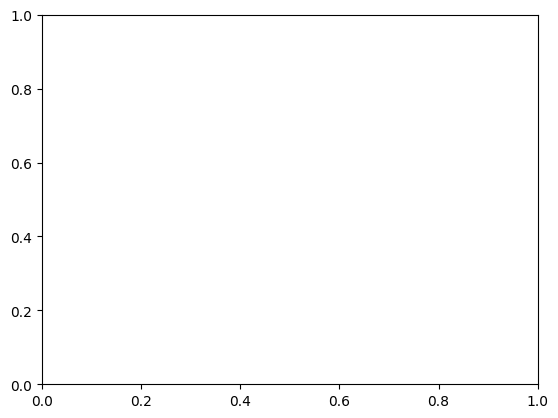

In [19]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

D = 512
batch_size = 32
x = coco_text_features_n
y = coco_text_features_laion2b
model = nn.Linear(D, D).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
loss_values = []  # 用于保存每个 epoch 的 loss

fig, ax = plt.subplots()
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
loss_values = []  # 用于保存每个 epoch 的平均 loss

pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_losses = []  # 记录每个 batch 的 loss
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    # 计算当前 epoch 的各项指标
    epoch_loss = np.mean(batch_losses)
    min_loss = np.min(batch_losses)
    max_loss = np.max(batch_losses)
    std_loss = np.std(batch_losses)

    # 使用 set_postfix 在进度条末尾显示当前 epoch 的指标
    pbar.set_postfix({
        "Avg Loss": f"{epoch_loss:.4f}",
        "Min Loss": f"{min_loss:.4f}",
        "Max Loss": f"{max_loss:.4f}",
        "Std": f"{std_loss:.4f}"
    })

In [24]:
dataset = TensorDataset(coco_text_features_n)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

coco_text_features_n_transformed = []
with torch.no_grad():
    for batch_x in dataloader:
        output = model(batch_x[0])
        coco_text_features_n_transformed.append(output)
    coco_text_features_n_transformed = torch.cat(coco_text_features_n_transformed, dim=0)

In [28]:
coco_cka_laion2b = linear_cka(coco_text_features_laion2b, replicate_features(coco_image_features_laion2b, 5))
coco_cka_n_transformed = linear_cka(coco_text_features_n_transformed, replicate_features(coco_image_features_laion2b, 5))
print("Triplet text encoder to Triplet image encoder CKA: {}".format(coco_cka_laion2b))
print("NegCLIP text encoder to Triplet image encoder CKA: {}".format(coco_cka_n_transformed))

Triplet text encoder to Triplet image encoder CKA: 0.9453414678573608
NegCLIP text encoder to Triplet image encoder CKA: 0.9519491195678711


In [ ]:
results_t = evaluate_retrieval(image_features_t, text_features_t)
results_n_transformed = evaluate_retrieval(image_features_t, text_features_n_transformed)
print(f'Image to Text (I2T) Top1  - TripletCLIP: {results_t["I2T_top1"]}, NegCLIP: {results_n_transformed["I2T_top1"]}')
print(f'Image to Text (I2T) Top5  - TripletCLIP: {results_t["I2T_top5"]}, NegCLIP: {results_n_transformed["I2T_top5"]}')
print(f'Image to Text (I2T) Top10 - TripletCLIP: {results_t["I2T_top10"]}, NegCLIP: {results_n_transformed["I2T_top10"]}')
print(f'Text to Image (T2I) Top1  - TripletCLIP: {results_t["T2I_top1"]}, NegCLIP: {results_n_transformed["T2I_top1"]}')
print(f'Text to Image (T2I) Top5  - TripletCLIP: {results_t["T2I_top5"]}, NegCLIP: {results_n_transformed["T2I_top5"]}')
print(f'Text to Image (T2I) Top10 - TripletCLIP: {results_t["T2I_top10"]}, NegCLIP: {results_n_transformed["T2I_top10"]}')

In [21]:
sim_pos_t, sim_neg_t = rotate_and_calc_similarity(image_features_t, text_features_t)
sim_pos_n_transformed, sim_neg_n_transformed = rotate_and_calc_similarity(image_features_t, text_features_n_transformed)
print(f'TripletCLIP Similarity    - Positive: {sim_pos_t}, Negative: {sim_neg_t}, PosNeg: {sim_pos_t - sim_neg_t}')
print(f'NegCLIP Similarity   - Positive: {sim_pos_n_transformed}, Negative: {sim_neg_n_transformed}, PosNeg: {sim_pos_n_transformed - sim_neg_n_transformed}')

TripletCLIP Similarity    - Positive: 0.7865129709243774, Negative: 0.6824867129325867, PosNeg: 0.10402625799179077
NegCLIP Similarity   - Positive: 0.7878443598747253, Negative: 0.6954525709152222, PosNeg: 0.09239178895950317


# Relative Modality Gap (RMG)

In [6]:
import torch.nn.functional as F

def chunked_cosine_distance_sum(A, B, chunk_size=1024, scaled=True, compute_diag=True):
    """
    分块计算 A, B 的 pairwise 余弦距离之和, 以及对角线之和(可选)。
    A.shape = (m, D), B.shape = (n, D)

    返回:
      total_sum = sum_{i=1}^m sum_{j=1}^n dist(A[i], B[j])
      diag_sum  = sum_{i=1}^min(m,n)} dist(A[i], B[i])  (仅当 compute_diag=True 且 m=n 时)
    """
    m, dA = A.shape
    n, dB = B.shape
    assert dA == dB, "A,B 的特征维度必须一致"

    # 只有 m == n 时才考虑对角线
    do_diag = compute_diag and (m == n)

    total_sum = 0.0
    diag_sum = 0.0

    # 分块遍历
    for i_start in range(0, m, chunk_size):
        i_end = min(m, i_start + chunk_size)
        A_chunk = A[i_start:i_end]  # shape = (i_batch, D)

        for j_start in range(0, n, chunk_size):
            j_end = min(n, j_start + chunk_size)
            B_chunk = B[j_start:j_end]  # shape = (j_batch, D)

            # 计算该分块的余弦相似度 (i_batch x j_batch)
            cos_sim = F.cosine_similarity(
                A_chunk.unsqueeze(1),  # (i_batch, 1, D)
                B_chunk.unsqueeze(0),  # (1, j_batch, D)
                dim=-1
            )

            # 转成余弦距离
            if scaled:
                # 余弦相似度 ∈ [-1,1], 距离映射到 [0,1]
                dist_chunk = (1.0 - cos_sim) / 2.0
            else:
                # 距离 ∈ [0,2]
                dist_chunk = 1.0 - cos_sim

            # 累加所有元素之和
            total_sum += dist_chunk.sum().item()

            # 如果需要对角线，且当前分块包含对角线部分
            if do_diag:
                # 对角线元素满足 i == j
                # 全局下标 k ∈ [i_start, i_end)，且同时 k ∈ [j_start, j_end)
                for offset in range(i_start, i_end):
                    k = offset  # 这是 X/Y 的全局索引
                    if j_start <= k < j_end:
                        local_i = k - i_start
                        local_j = k - j_start
                        diag_sum += dist_chunk[local_i, local_j].item()

    return total_sum, diag_sum


def compute_rmg_cos(X, Y, chunk_size=1024, scaled=True):
    """
    使用分块计算的余弦距离, 避免 OOM.
    X.shape = (N, D)
    Y.shape = (5N, D)  => 先 reshape => (N, 5, D) => 再对 dim=1 做 mean => (N, D)
    """
    # 0) Basic checks
    N, D = X.shape
    assert Y.shape[0] == 5 * N and Y.shape[1] == D, \
        f"Y must have shape (5N, D), but got {Y.shape}"

    # 1) 对 Y 做 reshape + mean => (N, 5, D) -> (N, D)
    Y = Y.view(N, 5, D)
    Y_avg = Y.mean(dim=1)  # shape = (N, D)

    # 2) 用分块方法得到 X-X, Y_avg-Y_avg, X-Y_avg 的 距离和 + 对角线和
    sum_xx, diag_xx   = chunked_cosine_distance_sum(X, X, chunk_size, scaled=scaled, compute_diag=True)
    sum_yy, diag_yy   = chunked_cosine_distance_sum(Y_avg, Y_avg, chunk_size, scaled=scaled, compute_diag=True)
    sum_xy, diag_xy   = chunked_cosine_distance_sum(X, Y_avg, chunk_size, scaled=scaled, compute_diag=True)

    # 3) 根据 RMG 公式计算:
    # numerator = (1/N) * sum_{i=1 to N} d(x_i, y_i)
    # denominator = [1/(2*N*(N-1))] * sum_{i!=j} [d(x_i, x_j) + d(y_i, y_j)] + numerator
    #
    # 注意:
    #   sum_xx 包含所有 i,j，包含对角线 diag_xx
    #   sum_xx_no_diag = sum_xx - diag_xx
    #   同理 sum_yy_no_diag = sum_yy - diag_yy
    #   diag_xy = sum_{i=1 to N} d(x_i, y_i)
    
    numerator = diag_xy / N

    sum_xx_no_diag = sum_xx - diag_xx
    sum_yy_no_diag = sum_yy - diag_yy

    first_term = (1.0 / (2.0 * N * (N - 1))) * (sum_xx_no_diag + sum_yy_no_diag)
    second_term = numerator  # same as above
    denominator = first_term + second_term

    rmg = numerator / denominator
    return rmg

In [22]:
import pandas as pd

rmg_t = compute_rmg_cos(coco_image_features_t, coco_text_features_t)
rmg_n = compute_rmg_cos(coco_image_features_n, coco_text_features_n)
rmg_l = compute_rmg_cos(coco_image_features_l, coco_text_features_l)
rmg_npp = compute_rmg_cos(coco_image_features_npp, coco_text_features_npp)
rmg_laion2b = compute_rmg_cos(coco_image_features_laion2b, coco_text_features_laion2b)

data = {
    "Metric": ["RMG"],
    "TripletCLIP": [rmg_t],
    "NegCLIP":     [rmg_n],
    "LaCLIP":      [rmg_l],
    "NegCLIP++":   [rmg_npp],
    "Laion2b": [rmg_laion2b],
}
df = pd.DataFrame(data)
print(df)

  Metric  TripletCLIP   NegCLIP    LaCLIP  NegCLIP++   Laion2b
0    RMG     0.702852  0.587989  0.553996   0.595561  0.508728


# Modality Gap Eigenfunction

## Top-k Modality Gap Dimension Difference

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_topk_differences_sorted(model_repr_pairs, top_k=16, plot=True):
    """
    参数：
      model_repr_pairs: dict, 形如
         {
            "ModelA": (image_repr_A, text_repr_A),
            "ModelB": (image_repr_B, text_repr_B),
            ...
         }
        其中 image_repr_X, text_repr_X 均为 numpy 数组或可转为 numpy 的 tensor, shape = (N, D)

      top_k: 取绝对差值排序后的前 K 个值
      plot:  是否在同一张图中绘制所有模型的曲线

    返回值：
      df_all: 一个 DataFrame，其中的行是 "Rank 1" ~ "Rank K"，列是各模型的名称。
              值是对应 rank 下的差值，不包含具体维度索引。
    """
    data = {}
    for model_name, (img_repr, txt_repr) in model_repr_pairs.items():
        # 如果是 torch.Tensor，这里转到 numpy (可根据需要先 .cpu())
        if hasattr(img_repr, "numpy"):
            img_repr = img_repr.cpu().numpy()
        if hasattr(txt_repr, "numpy"):
            txt_repr = txt_repr.cpu().numpy()
        
        # 1) 计算每个维度的均值差值
        mean_img = img_repr.mean(axis=0)  # shape=(D,)
        mean_txt = txt_repr.mean(axis=0)
        diff = np.abs(mean_img - mean_txt)  # shape=(D,)

        # 2) 从大到小排序
        sorted_diff = np.sort(diff)[::-1]  # 降序

        # 3) 取前 top_k
        topk_values = sorted_diff[:top_k]
        data[model_name] = topk_values

    # 4) 构造 DataFrame，行名 = Rank 1..K，列名 = 各模型
    ranks = [f"Rank {i+1}" for i in range(top_k)]
    df_all = pd.DataFrame(data, index=ranks)

    # 5) 可选绘图：将各模型的前K差值在同一张图中画曲线
    if plot:
        plt.figure(figsize=(8, 5))
        for model_name in data.keys():
            plt.plot(df_all[model_name].values, marker='o', label=model_name)
        plt.title("Top-K Mean Differences (Descending) for Each Model")
        plt.xlabel("Rank (1 = largest difference)")
        plt.ylabel("Absolute Mean Difference")
        plt.legend()
        plt.show()

    return df_all

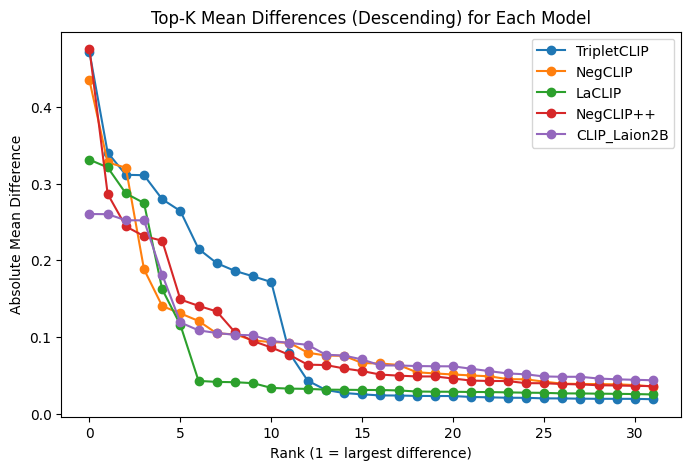

In [31]:
model_pairs = {
    "TripletCLIP": (coco_image_features_t.cpu().numpy(), coco_text_features_t.cpu().numpy()),
    "NegCLIP": (coco_image_features_n.cpu().numpy(), coco_text_features_n.cpu().numpy()),
    "LaCLIP": (coco_image_features_l.cpu().numpy(), coco_text_features_l.cpu().numpy()),
    "NegCLIP++": (coco_image_features_npp.cpu().numpy(), coco_text_features_npp.cpu().numpy()),
    "CLIP_Laion2B": (coco_image_features_laion2b.cpu().numpy(), coco_text_features_laion2b.cpu().numpy())
}
df_all = compare_topk_differences_sorted(model_pairs, top_k=32)

## Top-k Dim Mean/Var

### Image

In [8]:
def plot_multiple_models_sorted_stats(model_repr_dict, stat_type='mean', top_k=16):
    """
    参数:
      model_repr_dict: 字典，格式为{
           "ModelA": representation_A,  # numpy array (N, D) 或 torch.Tensor
           "ModelB": representation_B,
           ...
      }
      stat_type: 'mean' 或 'variance'，选择计算均值或方差
      top_k: 只展示排序后最大的前 top_k 个值
      
    说明:
      对于每个模型，计算 representation 在每个维度上的均值/方差，
      按从大到小排序后只取前 top_k 个，
      然后在同一张图中将各模型的排序结果（rank 1~top_k）绘制出来。
    """
    plt.figure(figsize=(8, 5))
    
    for model_name, repr_data in model_repr_dict.items():
        # 如果输入是 torch.Tensor，则转换为 numpy 数组（并确保在 CPU 上）
        if hasattr(repr_data, 'cpu'):
            repr_data = repr_data.cpu().numpy()
        
        if stat_type == 'mean':
            stats = repr_data.mean(axis=0)
            ylabel = 'Mean'
        elif stat_type == 'variance':
            stats = repr_data.var(axis=0)
            ylabel = 'Variance'
        else:
            raise ValueError("stat_type 必须为 'mean' 或 'variance'")
        
        # 按降序排序并取前 top_k 个
        sorted_stats = np.sort(stats)[::-1][:top_k]
        ranks = np.arange(1, top_k+1)  # Rank 1 到 Rank top_k
        
        plt.plot(ranks, sorted_stats, marker='o', label=model_name)
    
    plt.xlabel('Rank (1 = largest)')
    plt.ylabel(ylabel)
    plt.title(f"Top {top_k} {ylabel}s (Sorted Descending) for Multiple Models")
    plt.legend()
    plt.show()

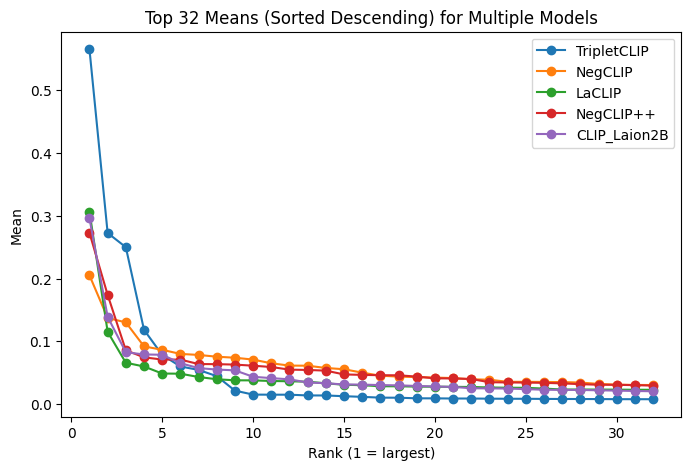

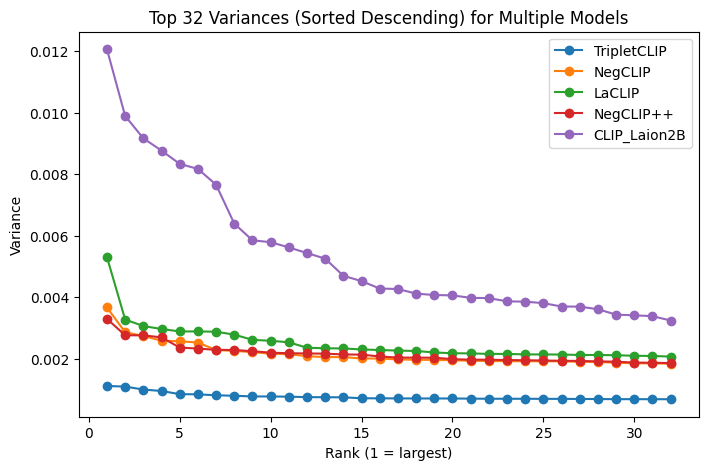

In [11]:
model_image_repr_dict = {
    "TripletCLIP": coco_image_features_t.cpu().numpy(),
    "NegCLIP": coco_image_features_n.cpu().numpy(),
    "LaCLIP": coco_image_features_l.cpu().numpy(),
    "NegCLIP++": coco_image_features_npp.cpu().numpy(),
    "CLIP_Laion2B": coco_image_features_laion2b.cpu().numpy()
}
plot_multiple_models_sorted_stats(model_image_repr_dict, stat_type='mean', top_k=32)
plot_multiple_models_sorted_stats(model_image_repr_dict, stat_type='variance', top_k=32)

### Text

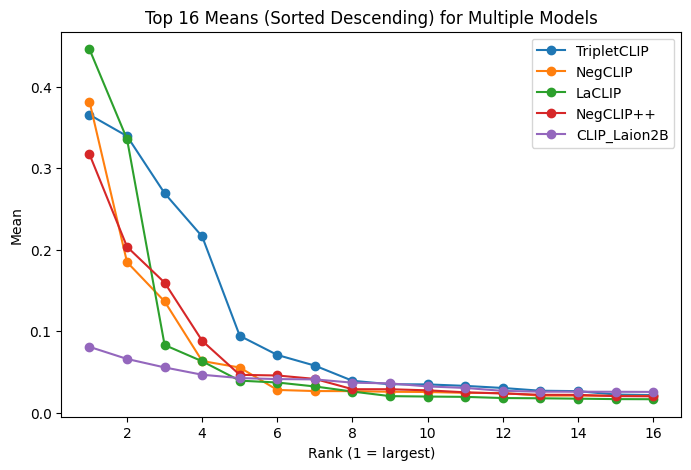

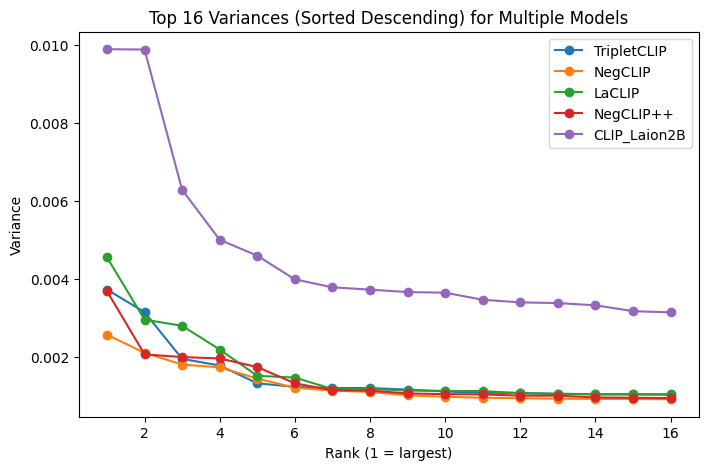

In [36]:
model_text_repr_dict = {
    "TripletCLIP": coco_text_features_t.cpu().numpy(),
    "NegCLIP": coco_text_features_n.cpu().numpy(),
    "LaCLIP": coco_text_features_l.cpu().numpy(),
    "NegCLIP++": coco_text_features_npp.cpu().numpy(),
    "CLIP_Laion2B": coco_text_features_laion2b.cpu().numpy()
}
plot_multiple_models_sorted_stats(model_text_repr_dict, stat_type='mean', top_k=16)
plot_multiple_models_sorted_stats(model_text_repr_dict, stat_type='variance', top_k=16)

## Top-k Modality Gap Dimension Mean/Var

### Image

In [9]:
def plot_multiple_models_repr_stats_sorted(model_repr_pairs, top_k=16):
    """
    对于多个模型的 representation pair，利用 image 和 text 均值的绝对差值进行降序排序，
    得到 top_k 个维度（排序顺序一致），然后分别提取 image 与 text 的均值和方差，
    并绘制4个图：Image Mean, Image Variance, Text Mean, Text Variance。
    
    参数:
      model_repr_pairs: dict, 格式为{
           "ModelA": (image_repr_A, text_repr_A),
           "ModelB": (image_repr_B, text_repr_B),
           ...
         }
         每个 representation 是 shape (N, D) 的 numpy 数组或 torch.Tensor
      top_k: 取 top_k 个维度进行分析
    
    返回:
      stats_dict: 字典，包含各模型按照排序后提取的各统计量数据，可用于后续进一步分析。
    """
    stats_dict = {}  # 用于存储各模型的排序数据
    
    for model_name, (img_repr, txt_repr) in model_repr_pairs.items():
        # 如果输入为 torch.Tensor，则转换为 numpy 数组（并确保在 CPU 上）
        if hasattr(img_repr, 'cpu'):
            img_repr = img_repr.cpu().numpy()
        if hasattr(txt_repr, 'cpu'):
            txt_repr = txt_repr.cpu().numpy()
        
        # 计算每个维度的均值和方差（沿样本轴）
        img_mean = img_repr.mean(axis=0)  # shape: (D,)
        img_var  = img_repr.var(axis=0)   # shape: (D,)
        txt_mean = txt_repr.mean(axis=0)
        txt_var  = txt_repr.var(axis=0)
        
        # 计算均值差值，并得到降序排序的索引
        diff = np.abs(img_mean - txt_mean)
        sorted_indices = np.argsort(diff)[::-1]  # 降序排序得到的维度索引
        
        # 取出 top_k 个维度的索引
        topk_indices = sorted_indices[:top_k]
        # 按照这个顺序提取各统计量
        sorted_img_mean = img_mean[topk_indices]
        sorted_img_var  = img_var[topk_indices]
        sorted_txt_mean = txt_mean[topk_indices]
        sorted_txt_var  = txt_var[topk_indices]
        
        stats_dict[model_name] = {
            'topk_indices': topk_indices,      # 如果需要知道具体维度，可查看此项
            'img_mean': sorted_img_mean,
            'img_var': sorted_img_var,
            'txt_mean': sorted_txt_mean,
            'txt_var': sorted_txt_var
        }
    
    # 设置 x 轴：Rank 1 到 Rank top_k（此处Rank 1 表示差值最大的那一维）
    ranks = np.arange(1, top_k+1)
    
    # 创建 4 个子图，2x2 布局
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # 图1：Image Representation Mean
    ax = axs[0, 0]
    for model_name, stats in stats_dict.items():
        ax.plot(ranks, stats['img_mean'], marker='o', label=model_name)
    ax.set_title("Image Mean (sorted by top difference)")
    ax.set_xlabel("Rank (1 = highest diff)")
    ax.set_ylabel("Mean")
    ax.legend()
    
    # 图2：Image Representation Variance
    ax = axs[0, 1]
    for model_name, stats in stats_dict.items():
        ax.plot(ranks, stats['img_var'], marker='o', label=model_name)
    ax.set_title("Image Variance (sorted by top difference)")
    ax.set_xlabel("Rank (1 = highest diff)")
    ax.set_ylabel("Variance")
    ax.legend()
    
    # 图3：Text Representation Mean
    ax = axs[1, 0]
    for model_name, stats in stats_dict.items():
        ax.plot(ranks, stats['txt_mean'], marker='o', label=model_name)
    ax.set_title("Text Mean (sorted by top difference)")
    ax.set_xlabel("Rank (1 = highest diff)")
    ax.set_ylabel("Mean")
    ax.legend()
    
    # 图4：Text Representation Variance
    ax = axs[1, 1]
    for model_name, stats in stats_dict.items():
        ax.plot(ranks, stats['txt_var'], marker='o', label=model_name)
    ax.set_title("Text Variance (sorted by top difference)")
    ax.set_xlabel("Rank (1 = highest diff)")
    ax.set_ylabel("Variance")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict

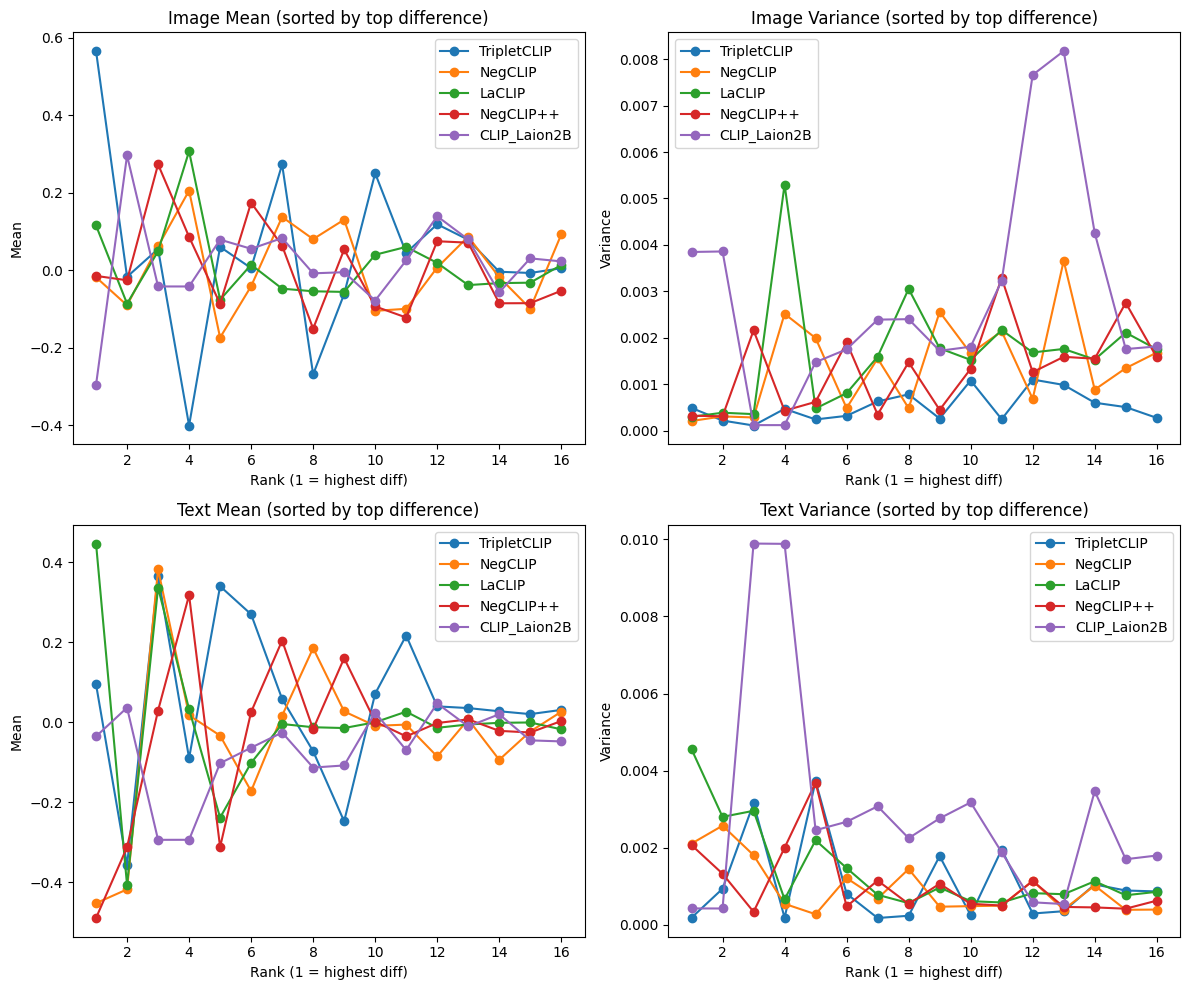

{'TripletCLIP': {'topk_indices': array([174, 344,  10, 164, 163, 321, 167, 380, 268, 330, 417,  51,  81,
         279, 471, 221]),
  'img_mean': array([ 0.56560063, -0.01734328,  0.05443117, -0.40128854,  0.05994068,
          0.00515905,  0.27268335, -0.26921618, -0.06189001,  0.25006866,
          0.044539  ,  0.1183874 ,  0.07834701, -0.00424578, -0.00744837,
          0.00482087], dtype=float32),
  'img_var': array([0.00049542, 0.00022403, 0.00011773, 0.00047588, 0.00024807,
         0.00032539, 0.0006352 , 0.00078777, 0.00026719, 0.00108542,
         0.000253  , 0.00110669, 0.00099038, 0.00060751, 0.00051334,
         0.00028161], dtype=float32),
  'txt_mean': array([ 0.09436709, -0.35767245,  0.36575913, -0.09043225,  0.33952582,
          0.26935786,  0.05776026, -0.07289344, -0.24815479,  0.07087629,
          0.21630225,  0.03919411,  0.03493328,  0.02697516,  0.01983096,
          0.03035846], dtype=float32),
  'txt_var': array([0.00018729, 0.00093814, 0.0031536 , 0.00018673,

In [15]:
model_repr_dict = {
    'TripletCLIP': (coco_image_features_t.cpu().numpy(), coco_text_features_t.cpu().numpy()),
    'NegCLIP': (coco_image_features_n.cpu().numpy(), coco_text_features_n.cpu().numpy()),
    'LaCLIP': (coco_image_features_l.cpu().numpy(), coco_text_features_l.cpu().numpy()),
    'NegCLIP++': (coco_image_features_npp.cpu().numpy(), coco_text_features_npp.cpu().numpy()),
    'CLIP_Laion2B': (coco_image_features_laion2b.cpu().numpy(), coco_text_features_laion2b.cpu().numpy())
}
plot_multiple_models_repr_stats_sorted(model_repr_dict, top_k=16)

## Reset Top=k Modality Gap dim

In [13]:
import torch
import pandas as pd

def reset_modality_gap_dim(image_features, text_features, top_k=1):
    """
    重置模态差距维度，返回修改后的 image 和 text 特征（均为 tensor）。
    参数：
      image_features: tensor，形状 (N, D)
      text_features: tensor，形状 (N, D)
      top_k: 选择 top_k 个模态差距最大的维度
    实现思路：
      1. 计算 image 和 text 各维度的均值，并计算它们的绝对差值。
      2. 根据差值降序排序，取出前 top_k 个维度索引。
      3. 将 image_features 中对应维度的值全部设为 text_features 在该维度的均值（广播至所有样本）。
    """
    # 注意使用 clone() 来避免直接修改原始 tensor
    image_features = image_features.clone()
    text_features = text_features.clone()
    
    # 计算每个维度的均值差值
    diff = torch.abs(image_features.mean(dim=0) - text_features.mean(dim=0))
    # 按降序排序，得到差值最大的维度索引
    _, sorted_indices = torch.sort(diff, descending=True)
    
    topk_indices = sorted_indices[:top_k]
    
    # 将 image_features 中 top_k 个维度设置为 text_features 在对应维度的均值
    image_features[:, topk_indices] = text_features.mean(dim=0)[topk_indices]
    
    return image_features, text_features


In [14]:
# 假设 coco_image_features_* 与 coco_text_features_* 都是 torch.Tensor，且已在 GPU 上
top_k = 1
coco_image_features_t_temp, coco_text_features_t_temp = reset_modality_gap_dim(
    coco_image_features_t, coco_text_features_t, top_k=top_k
)
coco_image_features_l_temp, coco_text_features_l_temp = reset_modality_gap_dim(
    coco_image_features_l, coco_text_features_l, top_k=top_k
)
coco_image_features_n_temp, coco_text_features_n_temp = reset_modality_gap_dim(
    coco_image_features_n, coco_text_features_n, top_k=top_k
)
coco_image_features_npp_temp, coco_text_features_npp_temp = reset_modality_gap_dim(
    coco_image_features_npp, coco_text_features_npp, top_k=top_k
)
coco_image_features_laion2b_temp, coco_text_features_laion2b_temp = reset_modality_gap_dim(
    coco_image_features_laion2b, coco_text_features_laion2b, top_k=top_k
)

# 调用 evaluate_retrieval 时保持 tensor 格式（evaluate_retrieval 内部需支持 tensor 操作或自行转换）
coco_retrieval_results_t_temp = evaluate_retrieval(coco_image_features_t_temp, coco_text_features_t_temp)
coco_retrieval_results_l_temp = evaluate_retrieval(coco_image_features_l_temp, coco_text_features_l_temp)
coco_retrieval_results_n_temp = evaluate_retrieval(coco_image_features_n_temp, coco_text_features_n_temp)
coco_retrieval_results_npp_temp = evaluate_retrieval(coco_image_features_npp_temp, coco_text_features_npp_temp)
coco_retrieval_results_laion2b_temp = evaluate_retrieval(coco_image_features_laion2b_temp, coco_text_features_laion2b_temp)

# 构造 DataFrame（此处仍使用 pandas 进行展示）
data = {
    "Metric": ["I2T_top1", "I2T_top5", "I2T_top10", "T2I_top1", "T2I_top5", "T2I_top10"],
    "TripletCLIP_temp_improve": [
        coco_retrieval_results_t_temp["I2T_top1"] - coco_retrieval_results_t["I2T_top1"],
        coco_retrieval_results_t_temp["I2T_top5"] - coco_retrieval_results_t["I2T_top5"],
        coco_retrieval_results_t_temp["I2T_top10"] - coco_retrieval_results_t["I2T_top10"],
        coco_retrieval_results_t_temp["T2I_top1"] - coco_retrieval_results_t["T2I_top1"],
        coco_retrieval_results_t_temp["T2I_top5"] - coco_retrieval_results_t["T2I_top5"],
        coco_retrieval_results_t_temp["T2I_top10"] - coco_retrieval_results_t["T2I_top10"]
    ],
    "LaCLIP_temp_improve": [
        coco_retrieval_results_l_temp["I2T_top1"] - coco_retrieval_results_l["I2T_top1"],
        coco_retrieval_results_l_temp["I2T_top5"] - coco_retrieval_results_l["I2T_top5"],
        coco_retrieval_results_l_temp["I2T_top10"] - coco_retrieval_results_l["I2T_top10"],
        coco_retrieval_results_l_temp["T2I_top1"] - coco_retrieval_results_l["T2I_top1"],
        coco_retrieval_results_l_temp["T2I_top5"] - coco_retrieval_results_l["T2I_top5"],
        coco_retrieval_results_l_temp["T2I_top10"] - coco_retrieval_results_l["T2I_top10"]
    ],
    "NegCLIP_temp_improve": [
        coco_retrieval_results_n_temp["I2T_top1"] - coco_retrieval_results_n["I2T_top1"],
        coco_retrieval_results_n_temp["I2T_top5"] - coco_retrieval_results_n["I2T_top5"],
        coco_retrieval_results_n_temp["I2T_top10"] - coco_retrieval_results_n["I2T_top10"],
        coco_retrieval_results_n_temp["T2I_top1"] - coco_retrieval_results_n["T2I_top1"],
        coco_retrieval_results_n_temp["T2I_top5"] - coco_retrieval_results_n["T2I_top5"],
        coco_retrieval_results_n_temp["T2I_top10"] - coco_retrieval_results_n["T2I_top10"]
    ],
    "NegCLIP++_temp_improve": [
        coco_retrieval_results_npp_temp["I2T_top1"] - coco_retrieval_results_npp["I2T_top1"],
        coco_retrieval_results_npp_temp["I2T_top5"] - coco_retrieval_results_npp["I2T_top5"],
        coco_retrieval_results_npp_temp["I2T_top10"] - coco_retrieval_results_npp["I2T_top10"],
        coco_retrieval_results_npp_temp["T2I_top1"] - coco_retrieval_results_npp["T2I_top1"],
        coco_retrieval_results_npp_temp["T2I_top5"] - coco_retrieval_results_npp["T2I_top5"],
        coco_retrieval_results_npp_temp["T2I_top10"] - coco_retrieval_results_npp["T2I_top10"]
    ],
    "CLIP_Laion2B_temp_improve": [
        coco_retrieval_results_laion2b_temp["I2T_top1"] - coco_retrieval_results_laion2b["I2T_top1"],
        coco_retrieval_results_laion2b_temp["I2T_top5"] - coco_retrieval_results_laion2b["I2T_top5"],
        coco_retrieval_results_laion2b_temp["I2T_top10"] - coco_retrieval_results_laion2b["I2T_top10"],
        coco_retrieval_results_laion2b_temp["T2I_top1"] - coco_retrieval_results_laion2b["T2I_top1"],
        coco_retrieval_results_laion2b_temp["T2I_top5"] - coco_retrieval_results_laion2b["T2I_top5"],
        coco_retrieval_results_laion2b_temp["T2I_top10"] - coco_retrieval_results_laion2b["T2I_top10"]
    ]
}

df = pd.DataFrame(data)
print(df)

      Metric  TripletCLIP_temp_improve  LaCLIP_temp_improve  \
0   I2T_top1                   0.00700             -0.02360   
1   I2T_top5                   0.01240             -0.06380   
2  I2T_top10                   0.01100             -0.07940   
3   T2I_top1                   0.00020             -0.00084   
4   T2I_top5                  -0.00172             -0.00356   
5  T2I_top10                  -0.00384             -0.00392   

   NegCLIP_temp_improve  NegCLIP++_temp_improve  CLIP_Laion2B_temp_improve  
0              -0.01580                -0.01160                    0.01120  
1              -0.02660                -0.01980                    0.00720  
2              -0.03460                -0.02680                    0.00660  
3              -0.00028                -0.00244                   -0.00324  
4              -0.00408                -0.00700                   -0.00540  
5              -0.00448                -0.00656                   -0.00396  


In [15]:
# 假设 coco_image_features_* 与 coco_text_features_* 都是 torch.Tensor，且已在 GPU 上
top_k = 2
coco_image_features_t_temp, coco_text_features_t_temp = reset_modality_gap_dim(
    coco_image_features_t, coco_text_features_t, top_k=top_k
)
coco_image_features_l_temp, coco_text_features_l_temp = reset_modality_gap_dim(
    coco_image_features_l, coco_text_features_l, top_k=top_k
)
coco_image_features_n_temp, coco_text_features_n_temp = reset_modality_gap_dim(
    coco_image_features_n, coco_text_features_n, top_k=top_k
)
coco_image_features_npp_temp, coco_text_features_npp_temp = reset_modality_gap_dim(
    coco_image_features_npp, coco_text_features_npp, top_k=top_k
)
coco_image_features_laion2b_temp, coco_text_features_laion2b_temp = reset_modality_gap_dim(
    coco_image_features_laion2b, coco_text_features_laion2b, top_k=top_k
)

# 调用 evaluate_retrieval 时保持 tensor 格式（evaluate_retrieval 内部需支持 tensor 操作或自行转换）
coco_retrieval_results_t_temp = evaluate_retrieval(coco_image_features_t_temp, coco_text_features_t_temp)
coco_retrieval_results_l_temp = evaluate_retrieval(coco_image_features_l_temp, coco_text_features_l_temp)
coco_retrieval_results_n_temp = evaluate_retrieval(coco_image_features_n_temp, coco_text_features_n_temp)
coco_retrieval_results_npp_temp = evaluate_retrieval(coco_image_features_npp_temp, coco_text_features_npp_temp)
coco_retrieval_results_laion2b_temp = evaluate_retrieval(coco_image_features_laion2b_temp, coco_text_features_laion2b_temp)

# 构造 DataFrame（此处仍使用 pandas 进行展示）
data = {
    "Metric": ["I2T_top1", "I2T_top5", "I2T_top10", "T2I_top1", "T2I_top5", "T2I_top10"],
    "TripletCLIP_temp_improve": [
        coco_retrieval_results_t_temp["I2T_top1"] - coco_retrieval_results_t["I2T_top1"],
        coco_retrieval_results_t_temp["I2T_top5"] - coco_retrieval_results_t["I2T_top5"],
        coco_retrieval_results_t_temp["I2T_top10"] - coco_retrieval_results_t["I2T_top10"],
        coco_retrieval_results_t_temp["T2I_top1"] - coco_retrieval_results_t["T2I_top1"],
        coco_retrieval_results_t_temp["T2I_top5"] - coco_retrieval_results_t["T2I_top5"],
        coco_retrieval_results_t_temp["T2I_top10"] - coco_retrieval_results_t["T2I_top10"]
    ],
    "LaCLIP_temp_improve": [
        coco_retrieval_results_l_temp["I2T_top1"] - coco_retrieval_results_l["I2T_top1"],
        coco_retrieval_results_l_temp["I2T_top5"] - coco_retrieval_results_l["I2T_top5"],
        coco_retrieval_results_l_temp["I2T_top10"] - coco_retrieval_results_l["I2T_top10"],
        coco_retrieval_results_l_temp["T2I_top1"] - coco_retrieval_results_l["T2I_top1"],
        coco_retrieval_results_l_temp["T2I_top5"] - coco_retrieval_results_l["T2I_top5"],
        coco_retrieval_results_l_temp["T2I_top10"] - coco_retrieval_results_l["T2I_top10"]
    ],
    "NegCLIP_temp_improve": [
        coco_retrieval_results_n_temp["I2T_top1"] - coco_retrieval_results_n["I2T_top1"],
        coco_retrieval_results_n_temp["I2T_top5"] - coco_retrieval_results_n["I2T_top5"],
        coco_retrieval_results_n_temp["I2T_top10"] - coco_retrieval_results_n["I2T_top10"],
        coco_retrieval_results_n_temp["T2I_top1"] - coco_retrieval_results_n["T2I_top1"],
        coco_retrieval_results_n_temp["T2I_top5"] - coco_retrieval_results_n["T2I_top5"],
        coco_retrieval_results_n_temp["T2I_top10"] - coco_retrieval_results_n["T2I_top10"]
    ],
    "NegCLIP++_temp_improve": [
        coco_retrieval_results_npp_temp["I2T_top1"] - coco_retrieval_results_npp["I2T_top1"],
        coco_retrieval_results_npp_temp["I2T_top5"] - coco_retrieval_results_npp["I2T_top5"],
        coco_retrieval_results_npp_temp["I2T_top10"] - coco_retrieval_results_npp["I2T_top10"],
        coco_retrieval_results_npp_temp["T2I_top1"] - coco_retrieval_results_npp["T2I_top1"],
        coco_retrieval_results_npp_temp["T2I_top5"] - coco_retrieval_results_npp["T2I_top5"],
        coco_retrieval_results_npp_temp["T2I_top10"] - coco_retrieval_results_npp["T2I_top10"]
    ],
    "CLIP_Laion2B_temp_improve": [
        coco_retrieval_results_laion2b_temp["I2T_top1"] - coco_retrieval_results_laion2b["I2T_top1"],
        coco_retrieval_results_laion2b_temp["I2T_top5"] - coco_retrieval_results_laion2b["I2T_top5"],
        coco_retrieval_results_laion2b_temp["I2T_top10"] - coco_retrieval_results_laion2b["I2T_top10"],
        coco_retrieval_results_laion2b_temp["T2I_top1"] - coco_retrieval_results_laion2b["T2I_top1"],
        coco_retrieval_results_laion2b_temp["T2I_top5"] - coco_retrieval_results_laion2b["T2I_top5"],
        coco_retrieval_results_laion2b_temp["T2I_top10"] - coco_retrieval_results_laion2b["T2I_top10"]
    ]
}

df = pd.DataFrame(data)
print(df)

      Metric  TripletCLIP_temp_improve  LaCLIP_temp_improve  \
0   I2T_top1                  -0.02460             -0.03920   
1   I2T_top5                  -0.05580             -0.10200   
2  I2T_top10                  -0.05780             -0.12300   
3   T2I_top1                  -0.00460             -0.00220   
4   T2I_top5                  -0.01172             -0.00432   
5  T2I_top10                  -0.01264             -0.00632   

   NegCLIP_temp_improve  NegCLIP++_temp_improve  CLIP_Laion2B_temp_improve  
0              -0.03160                -0.02180                    0.00820  
1              -0.06260                -0.04180                    0.00500  
2              -0.08460                -0.05680                    0.00920  
3              -0.00012                -0.00292                   -0.01432  
4              -0.00684                -0.00660                   -0.01548  
5              -0.00816                -0.01088                   -0.01148  
